In [1]:
# IMPORTING NECESSARY LIBRARIES
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# SUPRESS ALL WARNINGS
warnings.filterwarnings('ignore')

In [2]:
# IMPORTING OUR CSV FILE DIRECTLY FROM THE GOOGLE SHEET IN WHICH WE RECORDED OUR DATA
# SHEET LINK : https://docs.google.com/spreadsheets/d/1pftXBcsgMNHwQyMagbknVgnZ4JqYadUDP2KWW8-dBuc/edit#gid=1560113834

sheetid = "1pftXBcsgMNHwQyMagbknVgnZ4JqYadUDP2KWW8-dBuc"
df = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheetid}/export?format=csv")

In [3]:
# CONVERTING TIME TO MINS FROM DATE AND HRS:MIN:SEC FORMAT OF TIMESTAMP

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timefrommid'] = df['Timestamp'].dt.time

## EXPLORATORY DATA ANALYSIS

In [4]:
df.head()

,Timestamp,Day,Holiday,Meal_type,Extras,Veg,time_taken(mins),person,week,Timefrommid
0,2023-09-20 08:40:00,Wednesday,No,breakfast,No,Veg,18,koushik,1,08:40:00
1,2023-09-20 13:05:06,Wednesday,No,lunch,No,Veg,21,koushik,1,13:05:06
2,2023-09-20 21:52:06,Wednesday,No,dinner,No,Veg,16,koushik,1,21:52:06
3,2023-09-21 12:45:19,Thursday,No,breakfast,Yes,Veg,15,koushik,1,12:45:19
4,2023-09-21 12:59:54,Thursday,No,lunch,No,Veg,20,koushik,1,12:59:54


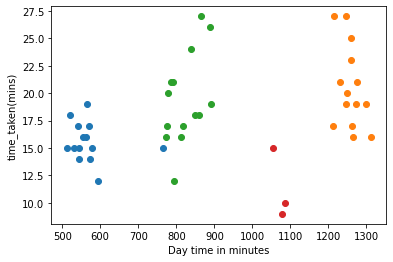

In [5]:
# Grouping data frames by meal_type
df['Time_minutesfrommid'] = df['Timefrommid'].apply(lambda x: x.hour * 60 + x.minute)
groups = df.groupby('Meal_type')


# Create a scatter plot for each group with different colors
for name, group in groups:
    plt.scatter(group['Time_minutesfrommid'], group['time_taken(mins)'], label=name)


# Add labels and a legend
plt.xlabel('Day time in minutes')
plt.ylabel('time_taken(mins)')


# Show the plot
plt.show()


#### PLOTS FOR CHOOSING APPROPRIATE DISTRIBUTION

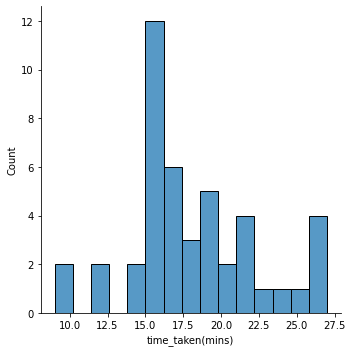

In [6]:
# Count in the below can be seen as frequency 
# frequency implying number of times we took that much time

sns.displot(df, x="time_taken(mins)", bins=15)

In [7]:
# This function takes time taken and meal type as arguments
# And plots bar plot, time vs day for that mealtype for both weeks

def bar_timetaken_vs_weekday(timel,type):
    X = ['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday','Tuesday']
    week1 = [timel[i] for i in range(7)]
    week2 = [timel[i+7] for i in range(len(timel)-7)]
    while(len(week2)<7):
        week2.append(0)
    x_axis = np.arange(len(X))
    plt.bar(x_axis - 0.2,week1, 0.4, label = 'week1')
    plt.bar(x_axis + 0.2,week2, 0.4, label = 'week2')
    plt.xticks(x_axis,X,rotation='vertical')
    plt.xlabel("Time taken for completing "+type)
    plt.legend()
    plt.show()


In [8]:
# This function prepares input arguments for above plotting function from our data

def mealtype_timel(type):
    df_type = df[df['Meal_type'] == type]
    temptime = df_type['time_taken(mins)']
    timel = list(temptime.values)
    bar_timetaken_vs_weekday(timel,type)
    
    

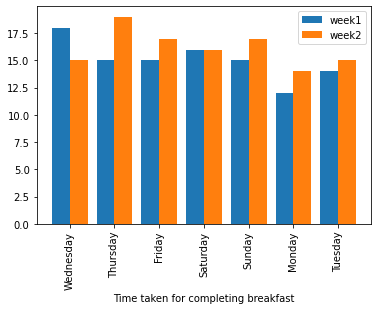

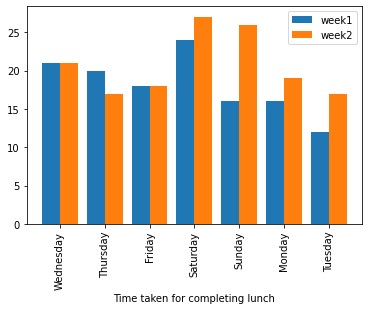

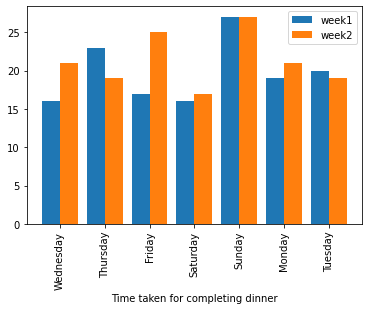

In [9]:
# Calling above function for different mealtypes to get the bar plots

mealtype_timel("breakfast")
mealtype_timel("lunch")
mealtype_timel("dinner")

## MODEL FITTING

In [10]:
# Creating a temporary data frame and we work on that,
# in case we need our original data frame.

pdf = df

In [11]:
# Libraries used for pre-processing purpose

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [12]:
# To convert non-numerical values to numerical values using label_encoder
label_encoder = preprocessing.LabelEncoder() 


# Encode labels in column 'days'.
pdf['Day']= label_encoder.fit_transform(pdf['Day'])
pdf['Meal_type']= label_encoder.fit_transform(pdf['Meal_type'])
pdf['Holiday']= label_encoder.fit_transform(pdf['Holiday'])
pdf['Extras']= label_encoder.fit_transform(pdf['Extras'])
pdf['Veg']= label_encoder.fit_transform(pdf['Veg'])
pdf['time_taken(mins)']= label_encoder.fit_transform(pdf['time_taken(mins)'])

In [13]:
# This is the ratio in which we split our training and testing data,
# So 80% training and 20% testing
ratio = 0.80

total_rows = pdf.shape[0]
train_size = int(total_rows*ratio)


# Split data into test and train
train = pdf[0:train_size]
test = pdf[train_size:]


# Dividing dataset, by separating their features and labels
# Here we choose first 80% of our data as training dataset and
# remaining 20% of our data as testing data set. 
X_train, y_train = train[['Day',	'Holiday',	'Meal_type',	'Extras',	'Veg']].values, train['time_taken(mins)'].values
X_test, y_test = test[['Day',	'Holiday',	'Meal_type',	'Extras',	'Veg']].values, test['time_taken(mins)'].values


In [14]:
# This function converts distribution of data in standard normal distribution
def standard_scaler(X):
    means = X.mean(0)
    stds = X.std(0)
    return (X - means)/stds

#### Model selection
 Assume that time taken for finishing the meal (T) is a random variable, from the plot of count vs time taken in mins we can infer that T is following possion distribution. log (lambda) in poisson regression can be modeled as linear combination of features (input). 
 Now we use gradient descent algorithm, 
 ##### beta_hats = beta_hats - (regularization constant)*(derivative of log likelihood with respect to beta's)



In [15]:
class PoissonRegression:
    
    # n_iter is number of iterations
    # lr is regularization constant
    def fit(self, X, y, n_iter = 1000, lr = 0.0002, add_intercept = True, standardize = False):
        
        # Try to get data in standard normal form for better training
        if standardize:
            X = standard_scaler(X)

        
        # Appending ones column to make our model as W0 + W^(T)X, here W0 is our intercept
        if add_intercept:
            ones = np.ones(len(X)).reshape((len(X), 1))
            X = np.append(ones, X, axis = 1)


        self.X = X
        self.y = y
        

        # Applying gradient decent to get the coeffiecients.
        beta_hats = np.zeros(X.shape[1])
        for i in range(n_iter):
            y_hat = np.exp(np.dot(X, beta_hats))
            dLdbeta = np.dot(X.T, y_hat - y)
            beta_hats -= lr*dLdbeta


        # beta_hats obtained here our the model parameters which were asked in question.
        self.beta_hats = beta_hats
        self.y_hat = y_hat
    

    # After we learned the model parameters, now we can use that model for prediction
    # This function below will predict on the input data points.
    def predict(self, X):
        ones = np.ones(len(X)).reshape((len(X), 1))
        X = np.append(ones, X, axis=1)

        # Used beta_hats coefficients obtained to predict on a given input x
        y_pred = np.exp(np.dot(X, self.beta_hats))
        return y_pred

    

        

#### Model results and performance metrics

In [17]:
# model is the object of the PoissonRegression class we created
model = PoissonRegression()

# calling fit method of our PoissonRegression class
model.fit(X_train, y_train,lr = .0002)

# after fitting now we pedict using the prect method of our PoissonRegression class
pred = model.predict(X_test)

In [22]:
# printing the actual y values in test data and the predicted y values of the model
print("Actual time taken (test set) :", y_test)
print("Predicted time taken using model (test set) :"  ,pred)

Actual time taken (test set) : [ 6 14 15  3  8 10  6  4  8]
Predicted time taken using model (test set) : [ 6.02016956 12.46170336 14.70856372  5.59945984  6.2344679   5.9084391
  6.13455302  4.42394968  5.81374923]


In [23]:
# se is the squared error
se = 0
for i in range(len(pred)):
    se += (pred[i] - y_test[i])**2

# calculating the mean of the squared error
mse = se/len(pred)
print("Mean Squared Error (our model using PoissonRegression) : "  ,mse)


Mean Squared Error (our model using PoissonRegression) :  3.7827104859217604


In [24]:
# Comparing the model which we created with the inbuilt LinearRegression model
from sklearn.linear_model import LinearRegression
multi_model = LinearRegression()
multi_model.fit(X_train,y_train)
predi = multi_model.predict(X_test)
se = 0
for i in range(len(predi)):
    se += (predi[i] - y_test[i])**2

mse = se/len(predi)
print("Mean Squared Error (inbuilt LinearRegression) : "  ,mse)


Mean Squared Error (inbuilt LinearRegression) :  4.077153952797184
